In [1]:
import pandas as pd
import numpy as np

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import nltk
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\michael\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## Import Data

In [77]:
data = pd.read_csv("train.csv",usecols=["id","comment_text", "toxic"])
# the data is too large to upload to github, but can be downloaded from the following link
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

#### The data used are Wikipedia comments which have been labeled by human raters for toxic behavior.    

In [4]:
data.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


## Data Cleaning and Pre-Processing

In [5]:
data.toxic.value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [6]:
# 10.6 percent of comments are toxic 
data[data["toxic"]==1].count()[1] / data[data["toxic"]==0].count()[1] *100

10.600442204925248

### 10.6% of comments are toxic 

In [7]:
# create a new column with the length of the comment 
data['comment_length'] = data['comment_text'].str.len()

In [8]:
data["length_log"] = data["comment_length"].apply(lambda x : np.log(x))

In [9]:
def number_of_upper(words):
    '''function to count the number of upper case letter in the comment'''
    return(sum(1 for c in words if c.isupper()))

In [10]:
# apply function to count number of uppercase letters in each comment 
data["number_uppercase"] = data['comment_text'].map(number_of_upper)

In [11]:
# create a new column that is the percent of words in the column that are upper case
data["percent_uppercase"] = data['number_uppercase'] / data['comment_length']

In [12]:
data.describe()

,toxic,comment_length,length_log,number_uppercase,percent_uppercase
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,394.073221,5.338712,17.159628,0.051622
std,0.294379,590.720282,1.110638,96.528103,0.092837
min,0.000000,6.000000,1.791759,0.000000,0.000000
25%,0.000000,96.000000,4.564348,3.000000,0.020710
50%,0.000000,205.000000,5.323010,7.000000,0.031746
75%,0.000000,435.000000,6.075346,15.000000,0.048830
max,1.000000,5000.000000,8.517193,4960.000000,0.998189


#### 159,571 Total Comments
#### Comment Length Range From 6 to 5000 Characters 
#### Percent of Character Uppercase Range from 0% to 0.998%
#### Log of the length has a Range from 1.79 to 8.5

## Examine percent toxic by percent uppercase

In [13]:
def bin_uppercase_2(df):
    '''Creates a function to turn Percent Uppercase into many binned groups'''
                        
    col="percent_uppercase"
    for x in range(5,105,5):
        if df[col]   <(x*0.01):
            return x

In [14]:
data["uppercase_binned_2"] = data.apply(bin_uppercase_2, axis=1)

In [15]:
# take a look at the change in percent toxic as the percent captilized increases. 
data.groupby("uppercase_binned_2")["toxic"].mean()

uppercase_binned_2
5      0.082449
10     0.086841
15     0.137597
20     0.185532
25     0.194969
30     0.184516
35     0.169946
40     0.234483
45     0.353488
50     0.511450
55     0.523810
60     0.593496
65     0.649682
70     0.649215
75     0.675758
80     0.680352
85     0.633484
90     0.600000
95     0.705882
100    0.750000
Name: toxic, dtype: float64

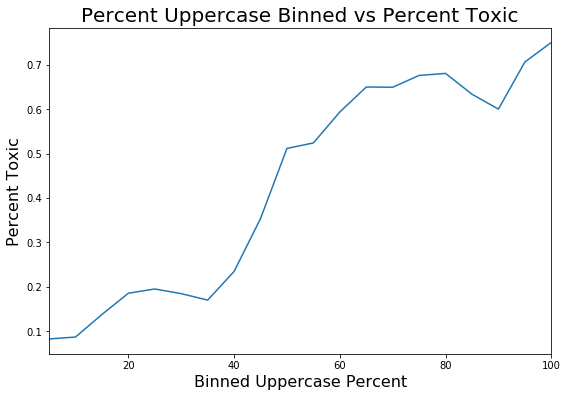

In [16]:
data.groupby("uppercase_binned_2")["toxic"].mean().plot(figsize=(9,6))
plt.title("Percent Uppercase Binned vs Percent Toxic",fontsize=20)
plt.ylabel("Percent Toxic",fontsize=16)
plt.xlabel("Binned Uppercase Percent",fontsize=16)
plt.show()

### based on the above plot and data the best bins for percent capitalization is as follow: 
### "0<10, 10<45, 45<55, 55< "

### Create Bins for Percent Uppercase

In [17]:
def bin_uppercase(df):
    '''Creates a function to turn Percent Uppercase into three binned groups'''
                        
    col="percent_uppercase"
    if df[col]   <0.1:
        return 1
    elif df[col] <0.45:
        return 2
    elif df[col] <0.55:
        return 3
    else:
        return 4

In [18]:
data["uppercase_binned"] = data.apply(bin_uppercase, axis=1)

In [19]:
data.groupby("uppercase_binned")["toxic"].mean()

uppercase_binned
1    0.083263
2    0.165660
3    0.517510
4    0.655610
Name: toxic, dtype: float64

In [20]:
data.groupby("uppercase_binned")["id"].count()

uppercase_binned
1    148493
2      8771
3       257
4      2050
Name: id, dtype: int64

Percent Uppercase Range | Count | Percent Toxic
--- | --- | ---
0 <= X < 0.1 | 148493 | 8.3%
0.1<=X< 0.45 | 8771 | 16.6%
0.45<=X< 0.55 | 257 | 51.8%
0.55 <= X | 2050 | 65.6%


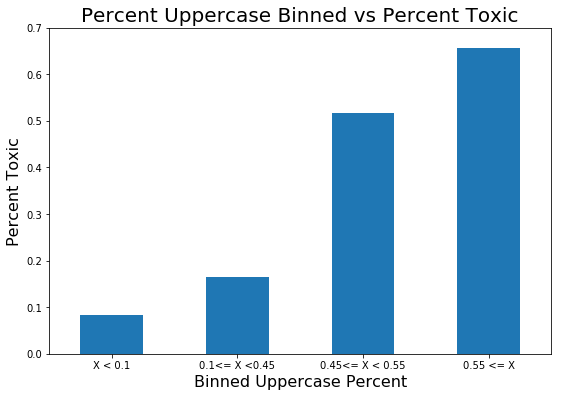

In [21]:
# plot the binned groups
data.groupby("uppercase_binned")["toxic"].mean().plot(kind="bar",figsize=(9,6))
plt.ylim(0,0.7)
plt.title("Percent Uppercase Binned vs Percent Toxic",fontsize=20)
plt.ylabel("Percent Toxic",fontsize=16)
plt.xlabel("Binned Uppercase Percent",fontsize=16)
plt.xticks([0,1,2,3],["X < 0.1","0.1<= X <0.45", "0.45<= X < 0.55","0.55 <= X"],rotation=0)
plt.show()

## Examine percent toxic by comment length

In [22]:
def bin_length_test(df):
    '''Creates a function to turn Percent Uppercase into three binned groups'''
                        
    col="comment_length"
    for x in range(100,5100,100):
        if df[col]   <x:
            return x

In [23]:
data["lenth_binned_2"] = data.apply(bin_length_test, axis=1)

In [24]:
# Look at possible binning distribution of Percent Toxic
data.groupby("lenth_binned_2")["toxic"].mean()

lenth_binned_2
100.0     0.155310
200.0     0.100325
300.0     0.076804
400.0     0.066613
500.0     0.060158
600.0     0.055875
700.0     0.055098
800.0     0.050379
900.0     0.046255
1000.0    0.050044
1100.0    0.049077
1200.0    0.043646
1300.0    0.049020
1400.0    0.044355
1500.0    0.038946
1600.0    0.039526
1700.0    0.033003
1800.0    0.048673
1900.0    0.043478
2000.0    0.028818
2100.0    0.038348
2200.0    0.059761
2300.0    0.059072
2400.0    0.052133
2500.0    0.055866
2600.0    0.083871
2700.0    0.071856
2800.0    0.034965
2900.0    0.072581
3000.0    0.046980
3100.0    0.052632
3200.0    0.023438
3300.0    0.056604
3400.0    0.090909
3500.0    0.069307
3600.0    0.067308
3700.0    0.039604
3800.0    0.052083
3900.0    0.051020
4000.0    0.055556
4100.0    0.079545
4200.0    0.108108
4300.0    0.037975
4400.0    0.098765
4500.0    0.131579
4600.0    0.073171
4700.0    0.068627
4800.0    0.133333
4900.0    0.078571
5000.0    0.439490
Name: toxic, dtype: float64

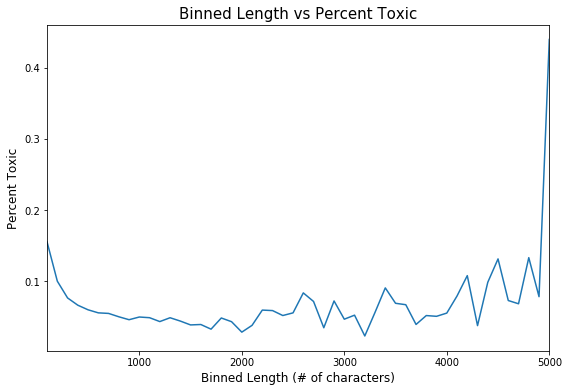

In [25]:
data.groupby("lenth_binned_2")["toxic"].mean().plot(figsize=(9,6))
plt.title("Binned Length vs Percent Toxic",fontsize=15)
plt.ylabel("Percent Toxic",fontsize=12)
plt.xlabel("Binned Length (# of characters)",fontsize=12)
plt.show()

In [26]:
# Look at possible binning distribution of comments 
data.groupby("lenth_binned_2")["toxic"].count()

lenth_binned_2
100.0     41575
200.0     36611
300.0     22590
400.0     15027
500.0      9741
600.0      6783
700.0      4973
800.0      3692
900.0      2897
1000.0     2298
1100.0     2058
1200.0     1558
1300.0     1224
1400.0      992
1500.0      873
1600.0      759
1700.0      606
1800.0      452
1900.0      460
2000.0      347
2100.0      339
2200.0      251
2300.0      237
2400.0      211
2500.0      179
2600.0      155
2700.0      167
2800.0      143
2900.0      124
3000.0      149
3100.0      114
3200.0      128
3300.0      106
3400.0      121
3500.0      101
3600.0      104
3700.0      101
3800.0       96
3900.0       98
4000.0       90
4100.0       88
4200.0       74
4300.0       79
4400.0       81
4500.0       76
4600.0       82
4700.0      102
4800.0      120
4900.0      140
5000.0      157
Name: toxic, dtype: int64

### Create Bins for Comment Length

In [27]:
def bin_length(df):
    '''Creates a function to turn Percent Uppercase into three binned groups'''
                        
    col="comment_length"
    if df[col]   <100:
        return 100
    elif df[col] <200:
        return 200
    elif df[col] <300:
        return 300
    elif df[col] <500:
        return 500
    elif df[col] <2500:
        return 2500
    else:
        return 4000

In [28]:
data["lenth_binned"] = data.apply(bin_length, axis=1)

In [29]:
# Look at final distribution for binned length  
data.groupby("lenth_binned")["toxic"].mean()

lenth_binned
100     0.155310
200     0.100325
300     0.076804
500     0.064075
2500    0.050018
4000    0.099366
Name: toxic, dtype: float64

In [30]:
# Look at final distribution for binned length  
data.groupby("lenth_binned")["toxic"].count()

lenth_binned
100     41575
200     36611
300     22590
500     24768
2500    31189
4000     2838
Name: toxic, dtype: int64

Comment Length Range | Count | Percent Toxic
--- | --- | ---
0 <= X  < 100 | 41575 | 15.5%
110 <=X< 200 | 36611 | 10%
200 <=X< 300 | 22590 | 7.7%
300 <=X< 500 | 24768 | 6.4%
500 <=X< 2500 | 31189 | 5.0%
2500 <= X | 2838 | 9.9%

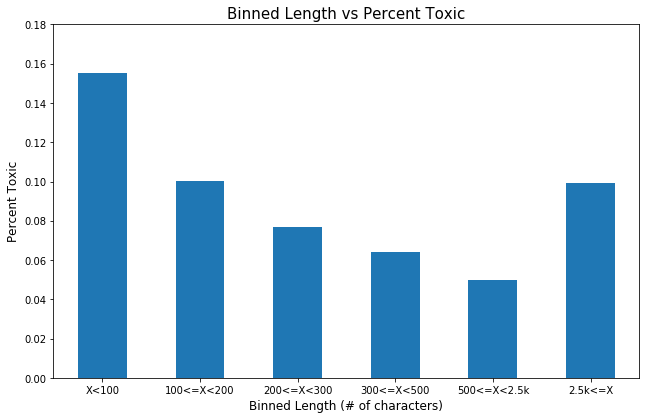

In [31]:
data.groupby("lenth_binned")["toxic"].mean().plot(kind="bar", figsize=(10.5,6.5))
plt.ylim(0,.18)
plt.title("Binned Length vs Percent Toxic",fontsize=15)
plt.ylabel("Percent Toxic",fontsize=12)
plt.xlabel("Binned Length (# of characters)",fontsize=12)
plt.xticks([0,1,2,3,4,5],["X<100","100<=X<200","200<=X<300", "300<=X<500","500<=X<2.5k", "2.5k<=X"],rotation=0)
plt.show()

## Examine log_length of length

In [32]:
def bin_length_test2(df):
    '''Creates a function to turn Percent Uppercase into three binned groups'''
                        
    col="length_log"
    for x in range(3,10,1):
        if df[col]   <x:
            return x

In [33]:
data["log_lenth_binned"] = data.apply(bin_length_test2, axis=1)

In [34]:
# Look at possible binning distribution of Percent Toxic
data.groupby("log_lenth_binned")["toxic"].mean()

log_lenth_binned
3    0.131349
4    0.170071
5    0.126759
6    0.077530
7    0.054863
8    0.045410
9    0.111215
Name: toxic, dtype: float64

In [35]:
data.groupby("log_lenth_binned")["toxic"].count()

log_lenth_binned
3      571
4    19486
5    41370
6    54843
7    31934
8     9227
9     2140
Name: toxic, dtype: int64

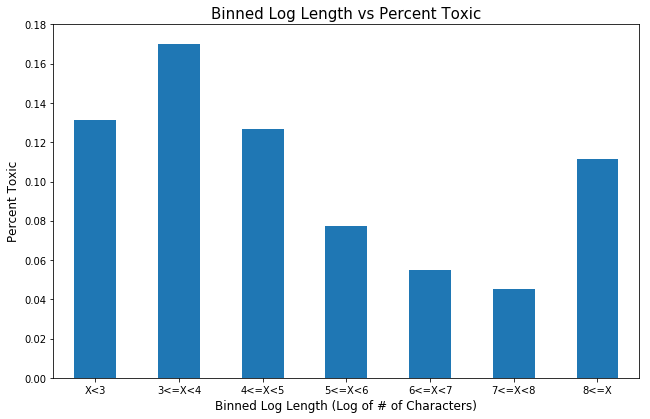

In [36]:
data.groupby("log_lenth_binned")["toxic"].mean().plot(kind="bar", figsize=(10.5,6.5))
plt.ylim(0,.18)
plt.title("Binned Log Length vs Percent Toxic",fontsize=15)
plt.ylabel("Percent Toxic",fontsize=12)
plt.xlabel("Binned Log Length (Log of # of Characters)",fontsize=12)
plt.xticks([0,1,2,3,4,5,6],["X<3","3<=X<4","4<=X<5", "5<=X<6","6<=X<7", "7<=X<8","8<=X"],rotation=0)
plt.show()

Comment Log Length Range | Count | Percent Toxic
--- | --- | ---
0 <= X  < 3 | 571 | 13.1%
3 <=X< 4 | 19486 | 17%
4 <=X< 5 | 41370 | 12.7%
5 <=X< 6 | 54843 | 7.8%
6 <=X< 7 | 31189 | 5.5%
7 <=X< 8 | 9227 | 4.5%
8<=X | 2140 | 11.1%

## Statistical Analysis of binned features

In [37]:
def chi_cont_func(col1,col2):
    a=data[data[col1]==0].groupby(col2)[[col1]].count()
    b= data[data[col1]==1].groupby(col2)[[col1]].count()
    data_array= np.concatenate((a.values.T,b.values.T),axis=0)
    return chi2_contingency(data_array)

In [38]:
chi_cont_func('toxic', 'lenth_binned')

(2844.1906350602294,
 0.0,
 5,
 array([[ 37590.26561844,  33102.03763215,  20424.87312858,  22394.12384456,
          28199.70641909,   2565.99335719],
        [  3984.73438156,   3508.96236785,   2165.12687142,   2373.87615544,
           2989.29358091,    272.00664281]]))

In [39]:
chi_cont_func('toxic', 'log_lenth_binned')

(2811.242671135296,
 0.0,
 6,
 array([[   516.2728002 ,  17618.37440387,  37404.91373746,  49586.60101773,
          28873.30227924,   8342.64295517,   1934.89280634],
        [    54.7271998 ,   1867.62559613,   3965.08626254,   5256.39898227,
           3060.69772076,    884.35704483,    205.10719366]]))

In [40]:
chi_cont_func('toxic', 'uppercase_binned')

(8704.2092241915743,
 0.0,
 3,
 array([[  1.34260765e+05,   7.93034804e+03,   2.32367968e+02,
           1.85351881e+03],
        [  1.42322348e+04,   8.40651961e+02,   2.46320321e+01,
           1.96481190e+02]]))

#### Running a Chi-Squared test for statistical independence for the binned uppercase and length variables results in a p-value of zero. This implies that both variables are statically significant in predicting whether a topic is toxic or benign. 

## Process Binned data for Machine Learning

In [41]:
# isolate the extra created columns using log length binned and uppercase binned
extra_data1 = data[["uppercase_binned","log_lenth_binned"]].astype(str)

# Use the get dummies function to turn these variables into boolian for machine learning analysis. 
extra_data = pd.get_dummies(extra_data1, drop_first=True).values

## Process text data 

In [42]:
# Create a new column to work on the text
data['clean_text'] = data['comment_text']

In [43]:
# remove new line, make lower case, remove apostrophe 

def remove_new_line(mystring):
    mystring = mystring.replace("\n", " ") #  removes the new line characters 
    mystring = mystring.lower()            # turns the whole string to lower case letters 
    mystring = mystring.replace("'", "")   # removes appostrophes 
    return(mystring)

In [44]:
# create regex that will allow for grabing only the words in the comments
prog = re.compile("[a-z]+")
#result = prog.findall(test_s_2)

In [45]:
def grab_words(words):
    '''grabs only the words from the comments and returns them in a string'''
    return(' '.join(prog.findall(words)))

In [46]:
def remove_stop_words(word_list):
    new_words = []
    for word in word_list:
        if not word in stopwords.words('english'):
            new_words.append(word)
    return(new_words)

### Run data pre-processing

In [47]:
data["clean_text"] = data["clean_text"].map(remove_new_line)

In [48]:
data["clean_text"] = data["clean_text"].map(grab_words)

###  Split the data for training and testing  

In [49]:
# Split the data for training and testing  
y = np.array(data.toxic , dtype=int)
X_train, X_test, Y_train, Y_test = train_test_split(data.clean_text, y, test_size=0.2, random_state=42)

### Build a Stemmer on the words 

In [50]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [51]:
analyzers = CountVectorizer(stop_words='english').build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzers(doc))

## Build ML Pipeline to Grid Search Count Vectorizer and Naive Bayes

In [64]:
count_vec = CountVectorizer(stop_words='english', ngram_range =(1,3))
clf_MNB = MultinomialNB()

steps = [('count_vec', count_vec),
         ('clf_MNB', clf_MNB)]

p_grid = [{'count_vec__min_df': [0, 10, 15, 20], 
         'count_vec__max_df': [0.2, 0.4, 0.6, 1.0], 
         'count_vec__max_features': [10000, 15000, 20000, None]
          , 'clf_MNB__alpha':[0.1, 1, 10]}] 

pipeline = Pipeline(steps)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
nb = GridSearchCV(pipeline, param_grid=p_grid, cv=skf,scoring= "roc_auc" ,  n_jobs=-1) 

In [65]:
nb.fit(X_train, Y_train)
nb.best_params_

{'clf_MNB__alpha': 1,
 'count_vec__max_df': 0.2,
 'count_vec__max_features': None,
 'count_vec__min_df': 15}

In [66]:
training_accuracy = nb.score(X_train, Y_train)
test_accuracy = nb.score(X_test, Y_test)
auc =  metrics.roc_auc_score(Y_test,nb.predict_proba(X_test)[:,1])
f1score = metrics.f1_score(Y_test, nb.predict(X_test))

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print("AUC on test data:          {:2f}".format(auc))
print("F1 Score on test data:     {:2f}".format(f1score))

Accuracy on training data: 0.956161
Accuracy on test data:     0.935896
AUC on test data:          0.935896
F1 Score on test data:     0.694770


#### From Grid searching we found the best hyperparameters were: alpha: 1, max_df':0.2, max_features': None, and min_df': 15

## Run Naive Bayes Classifier 

### Use Stemmed Data

In [52]:
stem_vector = CountVectorizer(analyzer=stemmed_words, ngram_range =(1,3), max_df=0.2, max_features=None, min_df=15)
X = stem_vector.fit_transform(data.clean_text)
X = X.tocsc()
y = np.array(data.toxic , dtype=int)

### Add in the other created data columns

In [53]:
X = hstack((X ,extra_data))
X = X.tocsc()

#### Continue with Test, Train Split

In [54]:
# Split the data for training and testing  
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train our model using what we found above from grid search

In [70]:
# create an instance of the Naive Bayes classifier 
mNB = MultinomialNB(alpha=1)
# fit the training data. 
mNB.fit(X_train, Y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

### Get Scores

In [71]:
training_accuracy = mNB.score(X_train, Y_train)
test_accuracy = mNB.score(X_test, Y_test)
auc =  metrics.roc_auc_score(Y_test,mNB.predict_proba(X_test)[:,1])
f1score = metrics.f1_score(Y_test, mNB.predict(X_test))

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print("AUC on test data:          {:2f}".format(auc))
print("F1 Score on test data:     {:2f}".format(f1score))

Accuracy on training data: 0.946027
Accuracy on test data:     0.943193
AUC on test data:          0.927640
F1 Score on test data:     0.719480


##  Apply a threshold

In [72]:
# We see how the f1-score and the accuracy of the algorithm change with different thresholds. 
thresh_list = np.arange(0.45,0.60,0.01)  
mNB_proba = mNB.predict_proba(X_test)[:,1]
print("Threshold---f1-score---accuracy")
for value in thresh_list:
    prediction = mNB_proba > value
    f1_score_v = metrics.f1_score(Y_test,prediction)
    total_score = metrics.accuracy_score(Y_test,prediction)
    print(value , f1_score_v, total_score )

Threshold---f1-score---accuracy
0.45 0.713420175704332 0.9407175309415635
0.46 0.7153306918622372 0.9414695284349052
0.47000000000000003 0.7171485390852073 0.9420648597838007
0.48000000000000004 0.7178620795576717 0.9424408585304715
0.49000000000000005 0.7190630297426415 0.9428795237349209
0.5 0.7194801175924492 0.9431928560238133
0.51 0.7214796394156046 0.9438508538304873
0.52 0.7228388307018915 0.9444461851793827
0.53 0.7239051954167322 0.9448848503838321
0.54 0.724724409448819 0.9452295159016136
0.55 0.7250039488232507 0.9454488485038384
0.56 0.7254559873116574 0.9457621807927307
0.5700000000000001 0.7255369928400955 0.9459501801660661
0.5800000000000001 0.725966145001597 0.9462321792260693
0.5900000000000001 0.7257573329059143 0.9463888453705155


#### Applying a threshold of greater than 0.55 gives the greatest F1-score of 0.725

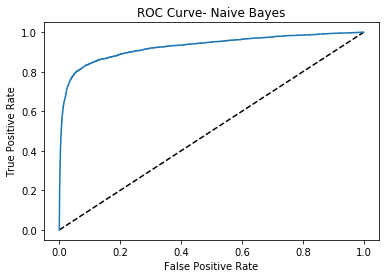

In [73]:
# ROC CURVE 

y_pred_prob = mNB.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Naive Bayes')
plt.show()

# Random Forest Classifier 

###  Split the data for training and testing  

In [75]:
# Split the data for training and testing  
y = np.array(data.toxic , dtype=int)
X_train, X_test, Y_train, Y_test = train_test_split(data.clean_text, y, test_size=0.2, random_state=42)

#### Grid search count vectorizer with ML pipeline 

In [76]:
count_vec = CountVectorizer(stop_words='english', ngram_range =(1,3))
rfc = RandomForestClassifier(n_jobs=-1, random_state = 42)

steps = [('count_vec', count_vec),
          ('rfc', rfc)]

p_grid = [{'count_vec__min_df': [0, 10, 15, 20], 
         'count_vec__max_df': [0.2, 0.4, 0.6, 1.0], 
         'count_vec__max_features': [10000, 15000, 20000, None] }] 

pipeline = Pipeline(steps)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
nb = GridSearchCV(pipeline, param_grid=p_grid, cv=skf,scoring= "roc_auc" ,  n_jobs=-1) 

In [77]:
nb.fit(X_train, Y_train)
nb.best_params_

{'count_vec__max_df': 0.2,
 'count_vec__max_features': None,
 'count_vec__min_df': 10}

#### Grid search found that for Random Forest the best perameters for the Count Vectorizer is:
#### max_df': 0.2 , max_features': None , min_df': 10

In [78]:
training_accuracy = nb.score(X_train, Y_train)
test_accuracy = nb.score(X_test, Y_test)
auc =  metrics.roc_auc_score(Y_test,nb.predict_proba(X_test)[:,1])
f1score = metrics.f1_score(Y_test, nb.predict(X_test))

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print("AUC on test data:          {:2f}".format(auc))
print("F1 Score on test data:     {:2f}".format(f1score))

Accuracy on training data: 0.999682
Accuracy on test data:     0.938614
AUC on test data:          0.938614
F1 Score on test data:     0.709111


#### Grid search Random Forest with ML pipeline 

## put in parameters from above 

In [79]:
count_vec = CountVectorizer(stop_words='english', ngram_range =(1,3), max_df=0.2, max_features=None, min_df=10)
rfc = RandomForestClassifier(n_jobs=-1, random_state = 42)

steps = [('count_vec', count_vec),
          ('rfc', rfc)]

p_grid = [{"rfc__max_depth": [3, None],
              "rfc__max_features": [1, 3, 10, 'auto'],
              "rfc__min_samples_split": [2, 3, 10],
              "rfc__min_samples_leaf": [1, 3, 10],
              "rfc__bootstrap": [True, False],
              "rfc__criterion": ["gini", "entropy"]}]

pipeline = Pipeline(steps)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
nb = GridSearchCV(pipeline, param_grid=p_grid, cv=skf,scoring= "roc_auc" ,  n_jobs=-1) 

In [80]:
nb.fit(X_train, Y_train)
nb.best_params_

{'rfc__bootstrap': False,
 'rfc__criterion': 'gini',
 'rfc__max_depth': None,
 'rfc__max_features': 'auto',
 'rfc__min_samples_leaf': 10,
 'rfc__min_samples_split': 2}

####  Grid search Random Forest parameters found: 
#### bootstrap: False, criterion': 'gini', max_depth': None, max_features': 'auto',min_samples_leaf': 10, min_samples_split': 2

In [81]:
training_accuracy = nb.score(X_train, Y_train)
test_accuracy = nb.score(X_test, Y_test)
auc =  metrics.roc_auc_score(Y_test,nb.predict_proba(X_test)[:,1])
f1score = metrics.f1_score(Y_test, nb.predict(X_test))

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print("AUC on test data:          {:2f}".format(auc))
print("F1 Score on test data:     {:2f}".format(f1score))

Accuracy on training data: 0.970732
Accuracy on test data:     0.955986
AUC on test data:          0.955986
F1 Score on test data:     0.615317


# Random Forest Classifier -- Stemmed Data 

### Use Stemmed Data

In [55]:
stem_vector = CountVectorizer(analyzer=stemmed_words, ngram_range =(1,3), max_df=0.2, max_features=None, min_df=10)
X = stem_vector.fit_transform(data.clean_text)
X = X.tocsc()
y = np.array(data.toxic , dtype=int)

### Add in the other created data columns

In [56]:
X = hstack((X ,extra_data))
X = X.tocsc()

#### Continue with Test, Train Split

In [57]:
# Split the data for training and testing  
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train our model using what we found above from grid search

In [58]:
# grid search found all the defaults parameters except for bootstrap and min_samples_leaf worked best
rfc = RandomForestClassifier(n_jobs=-1, random_state = 42, bootstrap= False, min_samples_leaf =10 )

In [59]:
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Score our new model

In [60]:
training_accuracy = rfc.score(X_train, Y_train)
test_accuracy = rfc.score(X_test, Y_test)
auc =  metrics.roc_auc_score(Y_test,rfc.predict_proba(X_test)[:,1])
f1score = metrics.f1_score(Y_test, rfc.predict(X_test))

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print("AUC on test data:          {:2f}".format(auc))
print("F1 Score on test data:     {:2f}".format(f1score))

Accuracy on training data: 0.943598
Accuracy on test data:     0.942911
AUC on test data:          0.957880
F1 Score on test data:     0.590746


### Apply threshold to improve F1 score

In [65]:
# We see how the f1-score and the accuracy of the algorithm change with different thresholds. 
thresh_list = np.arange(0.25,0.53,0.01)  
rf_proba = rfc.predict_proba(X_test)[:,1]
print("Threshold---f1-score---accuracy")
for value in thresh_list:
    prediction = rf_proba > value
    f1_score_v = metrics.f1_score(Y_test,prediction)
    total_score = metrics.accuracy_score(Y_test,prediction)
    print(value , f1_score_v, total_score )

Threshold---f1-score---accuracy
0.25 0.735196274118 0.950117499608
0.26 0.735457764289 0.950838163873
0.27 0.735832905324 0.951652827824
0.28 0.735983336226 0.952342158859
0.29 0.733309908644 0.952436158546
0.3 0.731029568935 0.952686824377
0.31 0.729339588596 0.953000156666
0.32 0.725508148691 0.953031489895
0.33 0.722211913156 0.953094156353
0.34 0.715523737754 0.952686824377
0.35 0.714367269267 0.952968823437
0.36 0.710632570659 0.952843490522
0.37 0.706270627063 0.952592824691
0.38 0.700589390963 0.952248159173
0.39 0.694891671636 0.951903493655
0.4 0.688537869583 0.951809493968
0.41 0.681548228548 0.951276829077
0.42 0.675753820735 0.950806830644
0.43 0.663310258024 0.949710167633
0.44 0.654960863127 0.948895503682
0.45 0.642260757868 0.947642174526
0.46 0.631965442765 0.946608177973
0.47 0.625054561327 0.946169512768
0.48 0.613180515759 0.945010183299
0.49 0.599955426789 0.943756854144
0.5 0.590745732255 0.942910856964
0.51 0.583389907219 0.942315525615
0.52 0.571559213535 0.9412

### By applying a threshold of greater than 0.29 we have a F1-Score of 0.73 with 95.3% test accuracy 

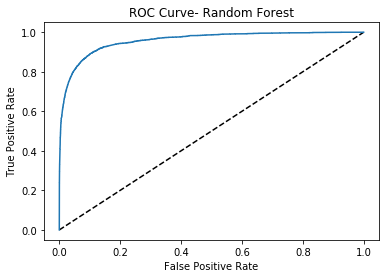

In [61]:
# ROC CURVE 

y_pred_prob_rf = rfc.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest')
plt.show()

### Most Important Features using Random Forest

#### Run a model without the added data to see which words are most important. 

In [71]:
stem_vector = CountVectorizer(analyzer=stemmed_words, ngram_range =(1,3), max_df=0.2, max_features=None, min_df=10)
X = stem_vector.fit_transform(data.clean_text)
X = X.tocsc()
y = np.array(data.toxic , dtype=int)
# Split the data for training and testing  
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# grid search found all the defaults parameters except for bootstrap and min_samples_leaf worked best
rfc_words = RandomForestClassifier(n_jobs=-1, random_state = 42, bootstrap= False, min_samples_leaf =10)
# fit model 
rfc_words.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [72]:
important_feature = pd.DataFrame(rfc_words.feature_importances_, index = np.array(stem_vector.get_feature_names()), columns =['importance']).sort_values('importance',ascending=False)

In [73]:
important_feature[:20]

,importance
fuck,0.214582
shit,0.047577
idiot,0.037592
bitch,0.035473
suck,0.034105
ass,0.030304
faggot,0.025427
cunt,0.023946
stupid,0.023185
asshol,0.022562
